# Kalman Sandbox

Testing the basic Kalman filter for linear system with hidden state $\beta$ where:

Measurement equation is $y = \alpha + \beta x + \epsilon_t$, which can be expressed as $y = \bf H \beta$

Or in matrix form: $\begin{bmatrix} y_t \\ y_{t-1} \\ y_{t-2} \\ \vdots \\ y_{t-n} \end{bmatrix} = 
\begin{bmatrix} 1 & x_{t, 1} & x_{t, 2} & \cdots & x_{t, n} \\ 
1 & x_{t-1, 1} & x_{t-1,2} & \cdots & x_{t-1,n} \\ 
1 & x_{t-2, 1} & x_{t-2,2} & \cdots & x_{t-2,n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\ 
1 & x_{t-n, 1} & x_{t-n,2} & \cdots & x_{t-n,n} \end{bmatrix} 
\begin{bmatrix} \alpha \\ \beta_1 \\ \beta_2 \\ \vdots \\ \beta_n \end{bmatrix}$

Prediction equation is assumed to be a random walk such that $\bar\beta = \bf F \beta = \beta = \begin{bmatrix} \alpha \\ \beta_1 \\ \beta_2 \\ \vdots \\ \beta_n \end{bmatrix}$

We will simulate $x_t$ to have normal variances $N(1, 10)$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from filterpy.kalman import KalmanFilter

In [2]:
betas1 = [3 for i in range(50)] + [6 for i in range(50)]
x = [np.random.normal(1, 10) for i in range(100)]
y1 = np.array(x) * np.array(betas1) + np.array([np.random.normal(0, 0.1) for i in range(len(x))])

In [3]:
class KF:
    def __init__(self, x0, lags=0):
        self.lags = lags
        kf = KalmanFilter(dim_x=lags+1, dim_z=lags+1)
        kf.x = x0
        kf.Q = 100
        kf.F = np.array([[1 for _ in range(self.lags+1)] for _ in range(self.lags+1)])
        self.kf = kf
        self.xs = {i: [] for i in range(self.lags+1)}
    
    def run(self, y_col, x_col, df):   
        # run filter
        self.kf.P = np.diag([df[f'{x_col}'].var() for i in range(self.lags+1)])
        self.kf.R = np.diag([df[f'{x_col}'].var() for i in range(self.lags+1)])
        df = df.dropna()
        for i in range(self.lags+1, len(df)):
            self.kf.predict()
            self.kf.H = np.array([[df.shift(l).iloc[i-j][f'{x_col}'] for l in range(self.lags+1)]
                                 for j in range(self.lags+1)]) # update H with fresh values
            self.kf.update(np.array([df.iloc[i-l][f'{y_col}'] for l in range(self.lags+1)]))
            for j in range(self.lags+1):
                self.xs[j].append(self.kf.x[j])
                
        return pd.DataFrame(self.xs, index=range(self.lags+1, len(df)))

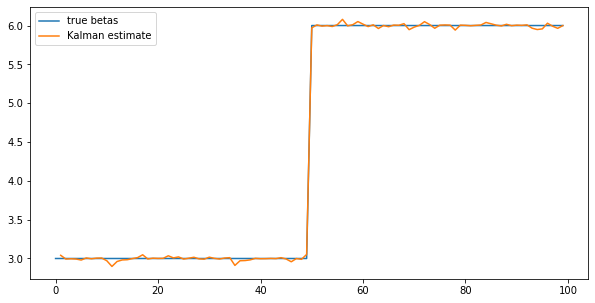

In [4]:
x0 = np.array([5])
kf = KF(x0).run('y', 'x', pd.DataFrame({'y': y1, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas1, label='true betas')
plt.plot(kf[0], label='Kalman estimate')
plt.legend()

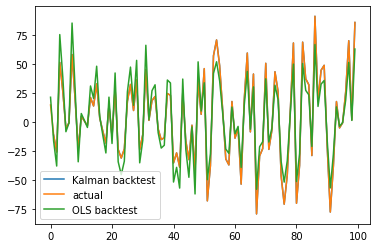

In [5]:
backtest_k = kf[0] * np.array(x[1:])
ols = sm.OLS(y1, 
             x).fit().params
backtest_o = ols[0] * np.array(x)
plt.plot(backtest_k, label='Kalman backtest')
plt.plot(y1, label='actual') # no need to cut y1 length because kf series starts from 1
plt.plot(backtest_o, label='OLS backtest')
plt.legend()

In [6]:
rmse_ols = np.sqrt(np.sum((y1 - backtest_o) ** 2) / len(backtest_o))
rmse_kalman = np.sqrt(np.sum((y1[1:] - backtest_k) ** 2) / len(backtest_k))
print(f'RMSE OLS: {rmse_ols}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE OLS: 11.948856475233416
RMSE Kalman: 0.034771615807769406


In [7]:
betas2 = [i * np.random.normal(1, 10) for i in range(100)]
y2 = np.array(x) * np.array(betas2) + np.array([np.random.normal(0, 10) for i in range(len(x))])

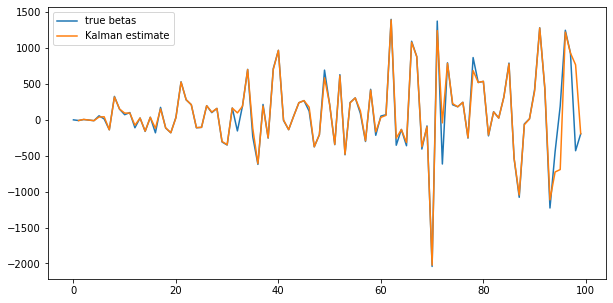

In [8]:
kf2 = KF(x0).run('y', 'x', pd.DataFrame({'y': y2, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas2, label='true betas')
plt.plot(kf2[0], label='Kalman estimate')
plt.legend()

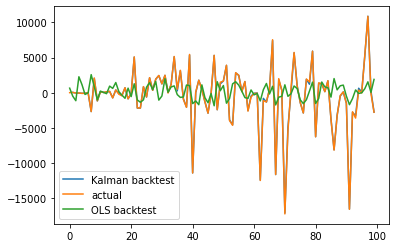

In [9]:
backtest_k = kf2[0] * np.array(x[1:])
ols = sm.OLS(y2, 
             x).fit().params

backtest_o = ols[0] * np.array(x)
plt.plot(backtest_k, label='Kalman backtest')
plt.plot(y2, label='actual') # no need to cut y1 length because kf series starts from 1
plt.plot(backtest_o, label='OLS backtest')
plt.legend()

In [10]:
rmse_ols = np.sqrt(np.sum((y2 - backtest_o) ** 2) / len(backtest_o))
rmse_kalman = np.sqrt(np.sum((y2[1:] - backtest_k) ** 2) / len(backtest_k))
print(f'RMSE OLS: {rmse_ols}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE OLS: 4072.303530730767
RMSE Kalman: 127.7851631582251


Finally we simulate a trend.

In [11]:
betas3 = [100 + i + np.random.normal(1, 10) for i in range(100)]
y3 = np.array(x) * np.array(betas3) + np.array([np.random.normal(0, 10) for i in range(len(x))])

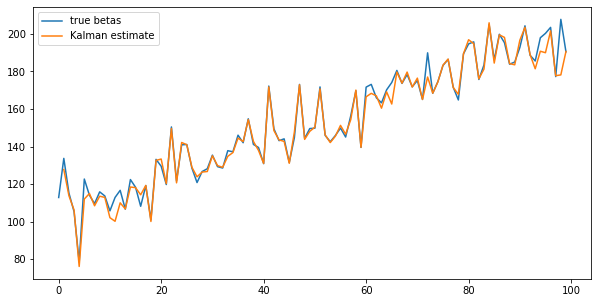

In [12]:
kf3 = KF(x0).run('y', 'x', pd.DataFrame({'y': y3, 'x': x}))

plt.figure(figsize=(10,5))
plt.plot(betas3, label='true betas')
plt.plot(kf3[0], label='Kalman estimate')
plt.legend()

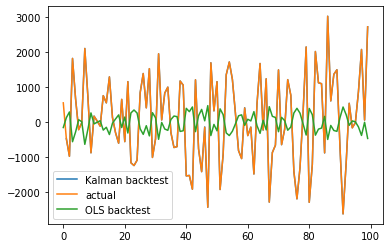

In [13]:
backtest_k = kf3[0] * np.array(x[1:])
ols = sm.OLS(y3, 
             sm.add_constant(x)).fit().params

backtest_o = ols[0] * np.array(x)
plt.plot(backtest_k, label='Kalman backtest')
plt.plot(y3, label='actual') # no need to cut y1 length because kf series starts from 1
plt.plot(backtest_o, label='OLS backtest')
plt.legend()

In [14]:
rmse_ols = np.sqrt(np.sum((y3 - backtest_o) ** 2) / len(backtest_o))
rmse_kalman = np.sqrt(np.sum((y3[1:] - backtest_k) ** 2) / len(backtest_k))
print(f'RMSE OLS: {rmse_ols}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE OLS: 1495.0455102181834
RMSE Kalman: 2.9144568941068507


It seems that the short term rolling window is far more prone to noise, and a longer-term measurement sample allows a better fit to the underlying trend.